In [8]:
# === Shapley Value (SV) sampling approximation: core helpers (Fixed) ===
from __future__ import annotations
import itertools, math, time
from typing import Tuple, Dict, Any, Optional, List, Literal, Sequence

import numpy as np
import pandas as pd

EPS = 1e-9

def _sv_edge_shares_exact(weights_e: np.ndarray, a_e: float, d: int) -> np.ndarray:
    """Exact Shapley shares on one edge; closed-form for d=2, else permutation average."""
    m = len(weights_e)
    if m == 0:
        return np.zeros(0, dtype=float)
    if d == 2:
        total_w = float(weights_e.sum())
        return a_e * weights_e * total_w
    shares = np.zeros(m, dtype=float)
    idxs = np.arange(m)
    for perm in itertools.permutations(idxs):
        prefix = 0.0
        for j in perm:
            wj = float(weights_e[j])
            shares[j] += a_e * ((prefix + wj)**d - (prefix**d))
            prefix += wj
    shares /= math.factorial(m)
    return shares


def _sv_edge_shares_perm_mc(weights_e: np.ndarray,
                            a_e: float,
                            d: int,
                            K: int,
                            rng: np.random.Generator,
                            stratified: bool = True) -> np.ndarray:
    """Permutation-MC estimator for edge-level Shapley; with a simple rotation heuristic."""
    m = len(weights_e)
    if m == 0:
        return np.zeros(0, dtype=float)
    if K < 1:
        raise ValueError("K must be >= 1 for permutation sampling.")
    if d == 2:
        total_w = float(weights_e.sum())
        return a_e * weights_e * total_w

    total = np.zeros(m, dtype=float)
    half = K // 2 if stratified and m > 1 else 0

    # Plain permutations
    for _ in range(K - half):
        perm = rng.permutation(m)
        prefix = 0.0
        for j in perm:
            wj = float(weights_e[j])
            total[j] += a_e * ((prefix + wj)**d - (prefix**d))
            prefix += wj

    # Rotation heuristic to diversify positions
    for _ in range(half):
        perm = rng.permutation(m)
        rot = int(rng.integers(0, m))
        perm = np.roll(perm, rot)
        prefix = 0.0
        for j in perm:
            wj = float(weights_e[j])
            total[j] += a_e * ((prefix + wj)**d - (prefix**d))
            prefix += wj

    return total / K


def _calculate_costs_for_active_set(
    instance: Any,
    paths: List[Tuple[int, ...]],
    active_players: np.ndarray,
    K_perm: int,
    exact_perm_threshold: int,
    rng: np.random.Generator
) -> np.ndarray:
    """Compute SV cost vector for a given active set (paths are precomputed)."""
    n = instance.n
    d = instance.d
    weights = instance.weights
    a = instance.a_coeffs
    num_e = instance.num_resources

    costs = np.zeros(n, dtype=float)
    if active_players.size == 0:
        return costs

    for e in range(num_e):
        mask = [i for i in active_players if e in paths[i]]
        if not mask:
            continue
        loc = np.array(mask, dtype=int)
        wloc = weights[loc].astype(float, copy=False)

        if (d == 2) or (len(loc) <= exact_perm_threshold):
            shares = _sv_edge_shares_exact(wloc, float(a[e]), d)
        else:
            shares = _sv_edge_shares_perm_mc(wloc, float(a[e]), d, K_perm, rng, stratified=True)
        costs[loc] += shares
    return costs


def expected_costs_sv(
    instance: Any,
    profile: Tuple[int, ...],
    p: float,
    *,
    types_mode: Literal["exact", "mc"] = "exact",
    K_types: int = 2000,
    K_perm: int = 1000,
    exact_perm_threshold: int = 8,
    rng: Optional[np.random.Generator] = None
) -> Dict[str, Any]:
    """Unconditional expected costs under SV; exact over types or MC over types."""
    if rng is None:
        rng = np.random.default_rng()

    n = instance.n
    paths = [instance.strategies[i][profile[i]] for i in range(n)]  # precompute
    total_costs = np.zeros(n, dtype=float)

    if types_mode == "exact":
        for mask in range(1 << n):
            k = mask.bit_count()
            prob = (p**k) * ((1.0 - p)**(n - k))
            if prob < EPS:
                continue
            active = np.array([i for i in range(n) if (mask >> i) & 1], dtype=int)
            contrib = _calculate_costs_for_active_set(
                instance, paths, active, K_perm, exact_perm_threshold, rng
            )
            total_costs += prob * contrib
    else:
        if K_types < 1:
            raise ValueError("K_types must be >= 1 for types MC.")
        for _ in range(K_types):
            types = rng.random(n) < p
            active = np.where(types)[0]
            contrib = _calculate_costs_for_active_set(
                instance, paths, active, K_perm, exact_perm_threshold, rng
            )
            total_costs += contrib
        total_costs /= K_types

    return {"player_costs": total_costs, "social_cost": float(total_costs.sum())}


def exact_expected_costs_sv_small(instance, profile: Tuple[int,...], p: float, rng=None) -> Dict[str, Any]:
    """Force exact types + exact perms (baseline for small n)."""
    return expected_costs_sv(instance, profile, p,
                             types_mode="exact", K_types=0,
                             K_perm=10_000,               # ignored when exact
                             exact_perm_threshold=10_000, # force exact perms
                             rng=rng)


def sv_sampling_benchmark(
    instance,
    profile: Tuple[int,...],
    p: float,
    K_perm_list: Sequence[int] = (10, 30, 100, 300, 1_000, 3_000, 10_000),
    K_types: int = 1_000,
    rng_seed: int = 1234
) -> pd.DataFrame:
    """
    Compare MC-permutation estimator vs exact baseline (small n).
    Returns a DataFrame with K_perm, wall_time, rmse (players & social), etc.
    """
    rng = np.random.default_rng(rng_seed)
    # exact baseline
    t0 = time.perf_counter()
    base = exact_expected_costs_sv_small(instance, profile, p, rng=rng)
    base_time = time.perf_counter() - t0
    base_costs = base["player_costs"]
    base_social = base["social_cost"]

    records = []
    types_mode = "exact" if instance.n <= 12 else "mc"

    for Kp in K_perm_list:
        t1 = time.perf_counter()
        est = expected_costs_sv(instance, profile, p,
                                types_mode=types_mode, K_types=K_types,
                                K_perm=Kp, exact_perm_threshold=8, rng=rng)
        dt = time.perf_counter() - t1

        err_vec = est["player_costs"] - base_costs
        rmse_players = float(np.sqrt(np.mean(err_vec**2)))
        rmse_social = float(abs(est["social_cost"] - base_social))
        records.append({
            "K_perm": Kp,
            "K_types": K_types if types_mode == "mc" else 0,
            "types_mode": types_mode,
            "wall_time_sec": dt,
            "baseline_time_sec": base_time,
            "rmse_players": rmse_players,
            "rmse_social": rmse_social,
            "est_social": est["social_cost"],
            "base_social": base_social
        })

    return pd.DataFrame.from_records(records)


# === CI-based stopping rule & Hoeffding ===

def ci_halfwidth_normal(mean: float, m2: float, n: int, delta: float) -> float:
    """Normal-approx half-width with running mean and second moment (m2=E[x^2])."""
    if n < 2:
        return float("inf")
    var = max(m2 - mean*mean, 0.0)
    # default 95%: z=1.96; very rough fallback for other delta
    z = 1.96 if abs(delta - 0.05) < 1e-6 else 2.576  # ~99% if不是0.05
    return z * math.sqrt(var / (n - 1))


def _get_single_sv_cost_sample(
    instance: Any,
    profile: Tuple[int, ...],
    p: float,
    types_mode: Literal["exact", "mc"],
    K_types: int,
    rng: np.random.Generator
) -> np.ndarray:
    """Produce ONE sample vector by forcing K_perm=1 and MC-perm (exact_perm_threshold=0)."""
    sample = expected_costs_sv(
        instance, profile, p,
        types_mode=types_mode,
        K_types=K_types,
        K_perm=1,
        exact_perm_threshold=0,
        rng=rng
    )
    return sample["player_costs"]


def sv_sampling_with_stopping(
    instance,
    profile: Tuple[int,...],
    p: float,
    *,
    max_K_samples: int = 50_000,
    check_interval: int = 50,
    eps_abs: Optional[float] = None,
    eps_rel: Optional[float] = 0.01,
    delta: float = 0.05,
    rng_seed: int = 2025
) -> Dict[str, Any]:
    """Stop when max per-player CI half-width <= max(eps_abs, eps_rel*|mean_i|)."""
    rng = np.random.default_rng(rng_seed)
    n = instance.n
    types_mode = "exact" if n <= 12 else "mc"
    K_types = 2000 if types_mode == "mc" else 0

    sums = np.zeros(n, dtype=float)
    sums_sq = np.zeros(n, dtype=float)
    k = 0
    history = []

    while k < max_K_samples:
        x = _get_single_sv_cost_sample(instance, profile, p, types_mode, K_types, rng)
        k += 1
        sums += x
        sums_sq += x**2

        if k % check_interval == 0:
            means = sums / k
            m2 = sums_sq / k
            half = np.array([ci_halfwidth_normal(means[i], m2[i], k, delta) for i in range(n)])
            thr = np.maximum(eps_abs if eps_abs is not None else 0.0,
                             (eps_rel if eps_rel is not None else 0.0) * np.abs(means))
            ok = np.all(half <= thr)
            history.append({"K_samples": k, "mean_costs": means.copy(),
                            "halfwidths": half.copy(), "thresholds": thr.copy(), "ok": bool(ok)})
            if ok:
                break

    means = sums / max(k,1)
    m2 = sums_sq / max(k,1)
    half = np.array([ci_halfwidth_normal(means[i], m2[i], k, delta) for i in range(n)])
    return {"status": "CONVERGED" if (history and history[-1]["ok"]) else "MAX_SAMPLES_REACHED",
            "K_samples": k, "estimate_player_costs": means, "halfwidths": half, "history": history}


def hoeffding_K_for_eps(range_width: float, eps: float, delta: float) -> int:
    """n >= ((b-a)^2 / (2 eps^2)) * ln(2/delta)"""
    if eps <= 0 or range_width <= 0:
        return 1
    return int(math.ceil((range_width**2) * math.log(2.0/delta) / (2.0 * eps**2)))


def rough_range_width_upper_bound(instance, d: int) -> float:
    """Very coarse upper bound on one-sample range width for a player."""
    w_min = float(np.min(instance.weights))
    w_max = float(np.max(instance.weights))
    W = instance.n * w_max
    range_per_edge = instance.a_coeffs * ((W**d) - ((W - w_min)**d))
    return float(np.sum(np.maximum(range_per_edge, 0.0)))


In [1]:
# ===================================================================
# Shapley Value (SV) sampling approximation — complete, corrected cell
# Generates data & plots for (b): estimator spec, K–RMSE/Time, bounds, stopping rule
# ===================================================================

from __future__ import annotations
import itertools, math, time
from typing import Sequence, Tuple, Any, Literal, Optional, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log, ceil  # keep for Hoeffding helper

EPS = 1e-9

# ---------------- Mock instance for demo ----------------
class MockInstance:
    """Tiny reproducible instance with 1 strategy per player."""
    def __init__(self, n: int, d: int, num_resources: int, seed: int = 42):
        rng = np.random.default_rng(seed)
        self.n = n
        self.d = d
        self.num_resources = num_resources
        self.weights = rng.uniform(0.5, 2.0, size=n)
        self.a_coeffs = rng.uniform(0.5, 1.5, size=num_resources)
        self.strategies = []
        for i in range(n):
            # robust: choose k in [1, max(1, num_resources//2)]
            hi = max(2, (num_resources // 2) + 1)  # upper bound is exclusive
            k = int(rng.integers(1, hi))
            path = tuple(sorted(rng.choice(num_resources, size=k, replace=False)))
            self.strategies.append([path])

# ---------------- Edge-level SV shares ----------------
def _sv_edge_shares_exact(weights_e: np.ndarray, a_e: float, d: int) -> np.ndarray:
    """Exact Shapley shares on one edge; closed-form for d=2, else permutation average."""
    m = len(weights_e)
    if m == 0:
        return np.zeros(0, dtype=float)
    if d == 2:
        total_w = float(weights_e.sum())
        return a_e * weights_e * total_w
    shares = np.zeros(m, dtype=float)
    idxs = np.arange(m)
    for perm in itertools.permutations(idxs):
        prefix = 0.0
        for j in perm:
            wj = float(weights_e[j])
            shares[j] += a_e * ((prefix + wj)**d - (prefix**d))
            prefix += wj
    shares /= math.factorial(m)
    return shares

def _sv_edge_shares_perm_mc(weights_e: np.ndarray,
                            a_e: float,
                            d: int,
                            K: int,
                            rng: np.random.Generator,
                            stratified: bool = True) -> np.ndarray:
    """Permutation-MC estimator for edge-level Shapley; adds a simple rotation heuristic."""
    m = len(weights_e)
    if m == 0:
        return np.zeros(0, dtype=float)
    if K < 1:
        raise ValueError("K must be >= 1 for permutation sampling.")
    if d == 2:
        total_w = float(weights_e.sum())
        return a_e * weights_e * total_w

    total = np.zeros(m, dtype=float)
    half = K // 2 if stratified and m > 1 else 0

    # Plain permutations
    for _ in range(K - half):
        perm = rng.permutation(m)
        prefix = 0.0
        for j in perm:
            wj = float(weights_e[j])
            total[j] += a_e * ((prefix + wj)**d - (prefix**d))
            prefix += wj

    # Rotation heuristic
    for _ in range(half):
        perm = rng.permutation(m)
        rot = int(rng.integers(0, m))
        perm = np.roll(perm, rot)
        prefix = 0.0
        for j in perm:
            wj = float(weights_e[j])
            total[j] += a_e * ((prefix + wj)**d - (prefix**d))
            prefix += wj

    return total / K

# ---------------- Type-layer expectation helpers ----------------
def _calculate_costs_for_active_set(instance: Any,
                                    paths: Sequence[Tuple[int, ...]],
                                    active_players: np.ndarray,
                                    K_perm: int,
                                    exact_perm_threshold: int,
                                    rng: np.random.Generator) -> np.ndarray:
    """Compute SV cost vector for a given active set (paths are precomputed)."""
    n, d = instance.n, instance.d
    weights, a = instance.weights, instance.a_coeffs
    num_e = instance.num_resources

    costs = np.zeros(n, dtype=float)
    if active_players.size == 0:
        return costs

    for e in range(num_e):
        mask = [i for i in active_players if e in paths[i]]
        if not mask:
            continue
        loc = np.array(mask, dtype=int)
        wloc = weights[loc].astype(float, copy=False)
        if d == 2 or len(loc) <= exact_perm_threshold:
            shares = _sv_edge_shares_exact(wloc, float(a[e]), d)
        else:
            shares = _sv_edge_shares_perm_mc(wloc, float(a[e]), d, K_perm, rng, stratified=True)
        costs[loc] += shares
    return costs

def expected_costs_sv(instance: Any,
                      profile: Tuple[int, ...],
                      p: float,
                      *,
                      types_mode: Literal["exact", "mc"] = "exact",
                      K_types: int = 2000,
                      K_perm: int = 1000,
                      exact_perm_threshold: int = 8,
                      rng: Optional[np.random.Generator] = None) -> Dict[str, Any]:
    """Unconditional expected costs under SV; exact over types or MC over types."""
    if rng is None:
        rng = np.random.default_rng()
    n = instance.n
    paths = [instance.strategies[i][profile[i]] for i in range(n)]  # precompute
    total_costs = np.zeros(n, dtype=float)

    if types_mode == "exact":
        for mask in range(1 << n):
            k = mask.bit_count()
            prob = (p**k) * ((1.0 - p)**(n - k))
            if prob < EPS:
                continue
            active = np.array([i for i in range(n) if (mask >> i) & 1], dtype=int)
            contrib = _calculate_costs_for_active_set(
                instance, paths, active, K_perm, exact_perm_threshold, rng
            )
            total_costs += prob * contrib
    else:
        if K_types < 1:
            raise ValueError("K_types must be >= 1 for MC over types.")
        for _ in range(K_types):
            types = rng.random(n) < p
            active = np.where(types)[0]
            contrib = _calculate_costs_for_active_set(
                instance, paths, active, K_perm, exact_perm_threshold, rng
            )
            total_costs += contrib
        total_costs /= K_types

    return {"player_costs": total_costs, "social_cost": float(total_costs.sum())}

def exact_expected_costs_sv_small(instance, profile: Tuple[int,...], p: float, rng=None) -> Dict[str, Any]:
    """Force exact types + exact permutations (baseline for small n)."""
    return expected_costs_sv(instance, profile, p,
                             types_mode="exact", K_types=0,
                             K_perm=10_000,               # ignored when exact perms
                             exact_perm_threshold=10_000, # force exact perms
                             rng=rng)

# ---------------- Benchmark: K vs RMSE & Time ----------------
def sv_sampling_benchmark(instance,
                          profile: Tuple[int,...],
                          p: float,
                          K_perm_list=(10, 30, 100, 300, 1_000, 3_000, 10_000),
                          K_types: int = 1_000,
                          rng_seed: int = 1234,
                          reps: int = 7) -> pd.DataFrame:
    """Compare MC-permutation estimator against exact baseline (for small n).
    Returns mean, std, and 95% CI over 'reps' trials for each K_perm.
    """
    # exact baseline (types exact + permutations exact)
    base = exact_expected_costs_sv_small(instance, profile, p, rng=np.random.default_rng(rng_seed))
    base_costs, base_social = base["player_costs"], base["social_cost"]

    master = np.random.default_rng(rng_seed)
    records = []
    types_mode = "exact" if instance.n <= 12 else "mc"

    for Kp in K_perm_list:
        rmse_list, time_list, rmse_social_list = [], [], []
        for _ in range(reps):
            rng = np.random.default_rng(int(master.integers(0, 2**31 - 1)))
            t1 = time.perf_counter()
            est = expected_costs_sv(
                instance, profile, p,
                types_mode=types_mode, K_types=K_types,
                K_perm=Kp,
                exact_perm_threshold=0,  # force MC on permutations
                rng=rng
            )
            dt = time.perf_counter() - t1
            err_vec = est["player_costs"] - base_costs
            rmse_list.append(float(np.sqrt(np.mean(err_vec**2))))
            rmse_social_list.append(float(abs(est["social_cost"] - base_social)))
            time_list.append(dt)

        # aggregate
        rmse = np.array(rmse_list)
        wtime = np.array(time_list)
        r_social = np.array(rmse_social_list)
        z = 1.96  # 95% CI
        rmse_mean, rmse_std = rmse.mean(), rmse.std(ddof=1)
        time_mean, time_std = wtime.mean(), wtime.std(ddof=1)
        r_soc_mean, r_soc_std = r_social.mean(), r_social.std(ddof=1)
        nrep = max(reps, 1)
        records.append({
            "K_perm": Kp,
            "rmse_players_mean": rmse_mean,
            "rmse_players_ci": z * rmse_std / np.sqrt(nrep),
            "rmse_social_mean": r_soc_mean,
            "rmse_social_ci": z * r_soc_std / np.sqrt(nrep),
            "wall_time_sec_mean": time_mean,
            "wall_time_sec_ci": z * time_std / np.sqrt(nrep),
            "reps": reps
        })
    return pd.DataFrame.from_records(records)



# ---------------- CI & stopping rule ----------------
def ci_halfwidth_normal(mean: float, m2: float, n: int, delta: float) -> float:
    """Normal-approx half-width with running mean and second moment (m2=E[x^2])."""
    if n < 2:
        return float("inf")
    var = max(m2 - mean*mean, 0.0)
    # default 95%: z=1.96; rough fallback for other delta
    z = 1.96 if abs(delta - 0.05) < 1e-6 else 2.576
    return z * math.sqrt(var / (n - 1))

def _get_single_sv_cost_sample(instance: Any,
                               profile: Tuple[int, ...],
                               p: float,
                               types_mode: Literal["exact", "mc"],
                               K_types: int,
                               rng: np.random.Generator) -> np.ndarray:
    """Produce ONE sample using K_perm=1 and MC perms (exact_perm_threshold=0)."""
    sample = expected_costs_sv(instance, profile, p,
                               types_mode=types_mode, K_types=K_types,
                               K_perm=1, exact_perm_threshold=0, rng=rng)
    return sample["player_costs"]

def sv_sampling_with_stopping(instance,
                              profile: Tuple[int,...],
                              p: float,
                              *,
                              max_K_samples: int = 50_000,
                              check_interval: int = 50,
                              eps_abs: Optional[float] = None,
                              eps_rel: Optional[float] = 0.01,
                              delta: float = 0.05,
                              rng_seed: int = 2025) -> Dict[str, Any]:
    """Stop when max per-player CI half-width <= max(eps_abs, eps_rel*|mean_i|)."""
    rng = np.random.default_rng(rng_seed)
    n = instance.n
    types_mode = "exact" if n <= 12 else "mc"
    K_types = 2000 if types_mode == "mc" else 0

    sums = np.zeros(n, dtype=float)
    sums_sq = np.zeros(n, dtype=float)
    k = 0
    history = []

    while k < max_K_samples:
        x = _get_single_sv_cost_sample(instance, profile, p, types_mode, K_types, rng)
        k += 1
        sums += x
        sums_sq += x**2

        if k % check_interval == 0:
            means = sums / k
            m2 = sums_sq / k
            half = np.array([ci_halfwidth_normal(means[i], m2[i], k, delta) for i in range(n)])
            thr = np.maximum(eps_abs if eps_abs is not None else 0.0,
                            (eps_rel if eps_rel is not None else 0.0) * np.abs(means))
            ok = np.all(half <= thr)
            history.append({"K_samples": k, "mean_costs": means.copy(),
                            "halfwidths": half.copy(), "thresholds": thr.copy(), "ok": bool(ok)})
            
            if ok and k >= check_interval:
                break

    means = sums / max(k, 1)
    m2 = sums_sq / max(k, 1)
    half = np.array([ci_halfwidth_normal(means[i], m2[i], k, delta) for i in range(n)])

    return {"status": "CONVERGED" if (history and history[-1]["ok"]) else "MAX_SAMPLES_REACHED",
            "K_samples": k, "estimate_player_costs": means, "halfwidths": half, "history": history}

# ---------------- Hoeffding bound helpers ----------------
def hoeffding_K_for_eps(range_width: float, eps: float, delta: float) -> int:
    """n >= ((b-a)^2 / (2 eps^2)) * ln(2/delta)"""
    if eps <= 0 or range_width <= 0:
        return 1
    return int(math.ceil((range_width**2) * math.log(2.0/delta) / (2.0 * eps**2)))

def rough_range_width_upper_bound(instance, d: int) -> float:
    """Very coarse upper bound on one-sample range width for a player."""
    w_min = float(np.min(instance.weights))
    w_max = float(np.max(instance.weights))
    W = instance.n * w_max
    range_per_edge = instance.a_coeffs * ((W**d) - ((W - w_min)**d))
    return float(np.sum(np.maximum(range_per_edge, 0.0)))

# ---------------- Convenience demos (optional to call) ----------------
def run_accuracy_runtime_benchmark():
    """Generate K–RMSE/Time curves with 95% CI bands (no reference slope, no grid)."""
    instance = MockInstance(n=9, d=3, num_resources=20)
    profile = tuple([0] * instance.n)
    p = 0.8

    print("--- Running SV Sampling Benchmark ---")
    df = sv_sampling_benchmark(
        instance, profile, p,
        K_perm_list=[10, 30, 100, 300, 1000, 3000, 10000],
        K_types=1000, rng_seed=2025, reps=7
    )
    print(df[["K_perm", "rmse_players_mean", "wall_time_sec_mean"]])

    # Plot
    fig, ax1 = plt.subplots(figsize=(9, 5.5))
    x = df["K_perm"].to_numpy()

    # Left y-axis: RMSE (players)
    y = df["rmse_players_mean"].to_numpy()
    yci = df["rmse_players_ci"].to_numpy()
    y_low = np.clip(y - yci, 1e-9, None)
    y_high = np.clip(y + yci, 1e-9, None)
    ax1.plot(x, y, marker="o", label="RMSE (players)")
    ax1.fill_between(x, y_low, y_high, alpha=0.2)
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_xlabel("Permutation samples (K_perm)")
    ax1.set_ylabel("RMSE (player costs)")

    # Right y-axis: time
    ax2 = ax1.twinx()
    t = df["wall_time_sec_mean"].to_numpy()
    tci = df["wall_time_sec_ci"].to_numpy()
    t_low = np.clip(t - tci, 1e-12, None)
    t_high = np.clip(t + tci, 1e-12, None)
    ax2.plot(x, t, marker="s", ls="--", color="tab:red", label="Wall-clock time")
    ax2.fill_between(x, t_low, t_high, alpha=0.15, color="tab:red")
    ax2.set_yscale("log")
    ax2.set_ylabel("Wall-clock time (s)")

    # No background gridlines
    # (intentionally omit ax1.grid / ax2.grid)

    # Compose legend (from both axes)
    lines, labels = [], []
    for ax in (ax1, ax2):
        L = ax.get_legend_handles_labels()
        lines += L[0]; labels += L[1]
    ax1.legend(lines, labels, loc='center left', bbox_to_anchor=(1.02, 0.5))

    fig.suptitle("SV estimator: accuracy vs runtime (mean ± 95% CI)")
    fig.tight_layout()
    plt.show()
    return df


def demonstrate_hoeffding_bound():
    """Print a Hoeffding-based sample complexity for a large-n instance."""
    inst = MockInstance(n=50, d=3, num_resources=100)
    epsilon, delta = 0.05, 0.05
    R = rough_range_width_upper_bound(inst, inst.d)
    K_needed = hoeffding_K_for_eps(R, epsilon, delta)
    print(f"[Hoeffding] n={inst.n}, d={inst.d}: range≈{R:.2f}, eps={epsilon}, 1-delta={1-delta:.2f} -> K≈{K_needed}")

def demonstrate_stopping_rule():
    """Run the adaptive sampler and plot CI convergence."""
    inst = MockInstance(n=9, d=3, num_resources=20)
    profile = tuple([0] * inst.n); p = 0.8
    res = sv_sampling_with_stopping(inst, profile, p,
                                    max_K_samples=50_000, check_interval=10,
                                    eps_abs=None, eps_rel=0.05, delta=0.05, rng_seed=2026)
    print(f"[Stopping] status={res['status']}, K={res['K_samples']}")
    hist = pd.DataFrame(res['history'])
    max_rel_hw = [np.max(h / (np.abs(m) + 1e-9)) for h, m in zip(hist['halfwidths'], hist['mean_costs'])]
    plt.plot(hist['K_samples'], max_rel_hw, marker='o')
    plt.axhline(0.05, ls='--', color='r', label='5% target')
    plt.xlabel('Samples K'); plt.ylabel('Max relative CI half-width')

    plt.legend(); plt.grid(True, ls='--', lw=0.5)
    plt.show()
    return res


--- Running SV Sampling Benchmark ---
   K_perm  rmse_players_mean  wall_time_sec_mean
0      10           4.710153            0.252552
1      30           2.650314            0.687923
2     100           1.740049            2.213689
3     300           0.817823            6.674316
4    1000           0.404729           24.604281
5    3000           0.318263           73.476801
6   10000           0.168798          254.984312


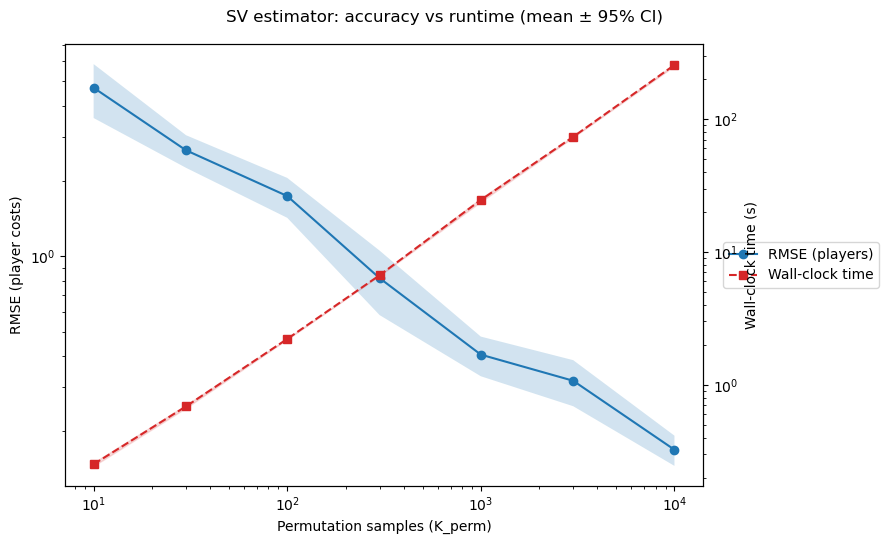

[Hoeffding] n=50, d=3: range≈1561218.70, eps=0.05, 1-delta=0.95 -> K≈1798257790545495
[Stopping] status=CONVERGED, K=40


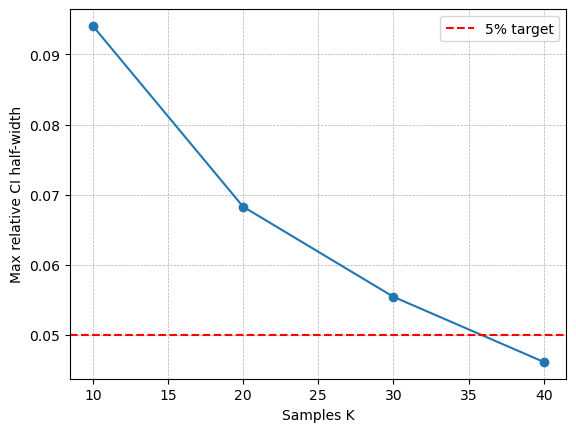

In [2]:
# --- Main execution block ---
if __name__ == '__main__':
    df_benchmark_results = run_accuracy_runtime_benchmark()
    demonstrate_hoeffding_bound()
    stopping_results = demonstrate_stopping_rule()

In [7]:
def demonstrate_hoeffding_bound2():
    """Print a Hoeffding-based sample complexity for a large-n instance."""
    inst = MockInstance(n=9, d=3, num_resources=20)
    epsilon, delta = 0.05, 0.05
    R = rough_range_width_upper_bound(inst, inst.d)
    K_needed = hoeffding_K_for_eps(R, epsilon, delta)
    print(f"[Hoeffding] n={inst.n}, d={inst.d}: range≈{R:.2f}, eps={epsilon}, 1-delta={1-delta:.2f} -> K≈{K_needed}")
demonstrate_hoeffding_bound2()

[Hoeffding] n=9, d=3: range≈11918.11, eps=0.05, 1-delta=0.95 -> K≈104794741605


In [4]:
def Plot(df):
    fig, ax1 = plt.subplots(figsize=(9, 5.5))
    x = df["K_perm"].to_numpy()

    # Left y-axis: RMSE (players)
    y = df["rmse_players_mean"].to_numpy()
    yci = df["rmse_players_ci"].to_numpy()
    y_low = np.clip(y - yci, 1e-9, None)
    y_high = np.clip(y + yci, 1e-9, None)
    ax1.plot(x, y, marker="o", label="RMSE (players)")
    ax1.fill_between(x, y_low, y_high, alpha=0.2)
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_xlabel("Permutation samples (K_perm)")
    ax1.set_ylabel("RMSE (player costs)")

    # Right y-axis: time
    ax2 = ax1.twinx()
    t = df["wall_time_sec_mean"].to_numpy()
    tci = df["wall_time_sec_ci"].to_numpy()
    t_low = np.clip(t - tci, 1e-12, None)
    t_high = np.clip(t + tci, 1e-12, None)
    ax2.plot(x, t, marker="s", ls="--", color="tab:red", label="Wall-clock time")
    ax2.fill_between(x, t_low, t_high, alpha=0.15, color="tab:red")
    ax2.set_yscale("log")
    ax2.set_ylabel("Wall-clock time (s)")

    # No background gridlines
    # (intentionally omit ax1.grid / ax2.grid)

    # Compose legend (from both axes)
    lines, labels = [], []
    for ax in (ax1, ax2):
        L = ax.get_legend_handles_labels()
        lines += L[0]; labels += L[1]
    ax1.legend(lines, labels, loc='center left')

    fig.suptitle("SV estimator: accuracy vs runtime (mean ± 95% CI)")
    fig.tight_layout()
    plt.show()

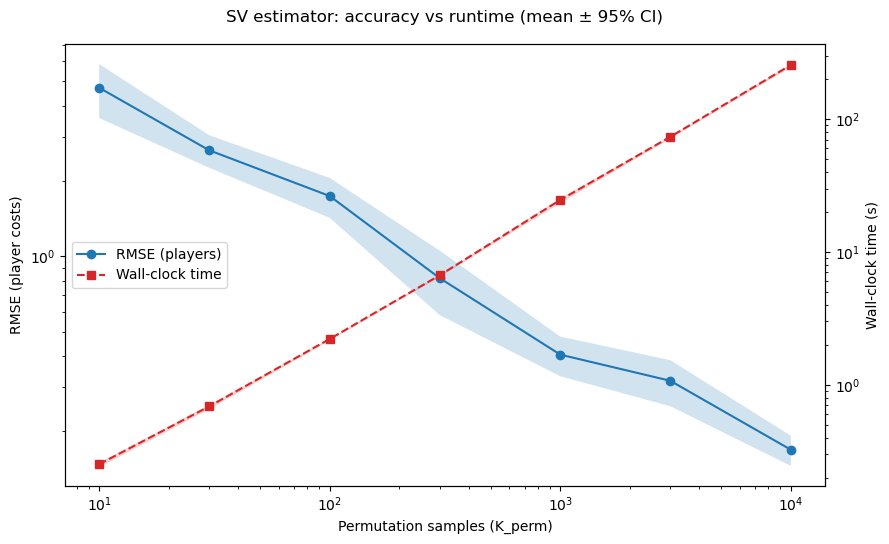

In [5]:
Plot(df_benchmark_results)

In [8]:
df_benchmark_results

,K_perm,rmse_players_mean,rmse_players_ci,rmse_social_mean,rmse_social_ci,wall_time_sec_mean,wall_time_sec_ci,reps
0,10,4.710153,1.144856,1.624098e-13,1.273293e-13,0.252552,0.007162,7
1,30,2.650314,0.394355,1.299278e-13,9.003538e-14,0.687923,0.017545,7
2,100,1.740049,0.315751,1.624098e-13,1.602191e-13,2.213689,0.015197,7
3,300,0.817823,0.235626,9.744586e-14,9.003538e-14,6.674316,0.037167,7
4,1000,0.404729,0.073001,6.171571e-13,1.273293e-13,24.604281,0.732950,7
5,3000,0.318263,0.066411,1.948917e-13,1.515521e-13,73.476801,0.654924,7
6,10000,0.168798,0.023315,9.094947e-12,9.724933e-14,254.984312,4.013139,7


In [9]:
stopping_results

{'status': 'CONVERGED',
 'K_samples': 40,
 'estimate_player_costs': array([209.57603408, 143.04114541, 261.49091973, 235.50235004,
         39.91126487, 162.78671004,  87.70651272, 254.76185078,
         21.17348443]),
 'halfwidths': array([6.46283179, 4.03717785, 6.43596165, 6.22440625, 1.6878331 ,
        4.6973643 , 3.82581888, 6.62282705, 0.97645282]),
 'history': [{'K_samples': 10,
   'mean_costs': array([206.5296646 , 139.05944801, 272.32366519, 234.27357816,
           40.10237304, 162.95160668,  90.26552405, 248.25663085,
           22.18778152]),
   'halfwidths': array([11.58712128,  5.98141052, 10.51204455,  9.54308796,  3.2764378 ,
          11.31116074,  7.52668833, 11.39323943,  2.08732299]),
   'thresholds': array([10.32648323,  6.9529724 , 13.61618326, 11.71367891,  2.00511865,
           8.14758033,  4.5132762 , 12.41283154,  1.10938908]),
   'ok': False},
  {'K_samples': 20,
   'mean_costs': array([212.42317675, 139.46412855, 268.49052217, 230.27341609,
           40.3

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_sv_benchmark_panels(df_benchmark_results: pd.DataFrame,
                             stopping_results: dict,
                             pdf_path="SV_benchmark_panels.pdf",
                             png_path="SV_benchmark_panels.png"):
    # ---- 全局排版（简洁学术风） ----
    plt.rcParams.update({
        "font.size": 12,
        "axes.titleweight": "bold",
        "axes.spines.top": False,
        "axes.spines.right": False,
        "savefig.bbox": "tight",
        "pdf.fonttype": 42,  
        "ps.fonttype": 42,
    })

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.6))
    ax1 = axes[0]

 
    df = df_benchmark_results.copy()
    x = df["K_perm"].to_numpy()


    y = df["rmse_players_mean"].to_numpy()
    yci = df["rmse_players_ci"].to_numpy()
    y_low = np.clip(y - yci, 1e-12, None)
    y_high = np.clip(y + yci, 1e-12, None)
    l1, = ax1.plot(x, y, marker="o", label="RMSE (players)")
    ax1.fill_between(x, y_low, y_high, alpha=0.20)

    ax1.set_xscale("log"); ax1.set_yscale("log")
    ax1.set_xlabel(r"Permutation samples $K$")
    ax1.set_ylabel("RMSE (player costs)")
    ax1.set_title("(a) Accuracy vs. runtime")

    # 右轴：时间（对数轴）
    ax1r = ax1.twinx()
    t = df["wall_time_sec_mean"].to_numpy()
    tci = df["wall_time_sec_ci"].to_numpy()
    t_low = np.clip(t - tci, 1e-12, None)
    t_high = np.clip(t + tci, 1e-12, None)
    l2, = ax1r.plot(x, t, marker="s", ls="--", label="Wall-clock time")
    ax1r.fill_between(x, t_low, t_high, alpha=0.15)
    ax1r.set_yscale("log")
    ax1r.set_ylabel("Wall-clock time (s)")

  
    lines, labels = [], []
    for ax in (ax1, ax1r):
        L = ax.get_legend_handles_labels()
        lines += L[0]; labels += L[1]
    ax1.legend(lines, labels, loc="upper center", frameon=False)


    ax2 = axes[1]
    hist = pd.DataFrame(stopping_results["history"])

    max_rel_hw = np.array([
        float(np.max(h / (np.abs(m) + 1e-9)))
        for h, m in zip(hist["halfwidths"], hist["mean_costs"])
    ])
    k_hist = hist["K_samples"].to_numpy()

    ax2.plot(k_hist, max_rel_hw, marker="o", label="max relative half-width")

    target = 0.05
    ax2.axhline(target, ls="--", label="5% target")
    k_stop = stopping_results.get("K_samples", None)
    if k_stop is not None:
        ax2.axvline(k_stop, ls=":", label=f"stop @ K={k_stop}")
    ax2.set_xlabel(r"Samples $K$")
    ax2.set_ylabel("Max relative 95% CI half-width")
    ax2.set_title("(b) Adaptive stopping (CI-based)")
    ax2.set_xlim(left=max(1, np.min(k_hist)))
    ax2.set_ylim(bottom=max(1e-4, np.min(max_rel_hw)*0.8))
    ax2.set_xscale("log"); ax2.set_yscale("log")
    ax2.legend(frameon=False, loc="upper right")

    # fig.suptitle("SV sampling: accuracy/runtime and CI-based stopping", y=1.02)
    fig.tight_layout()

    # 保存
    fig.savefig(pdf_path)
    fig.savefig(png_path, dpi=300)
    print(f"Saved: {pdf_path}, {png_path}")
    return fig, (ax1, ax2)


Saved: SV_benchmark_panels.pdf, SV_benchmark_panels.png


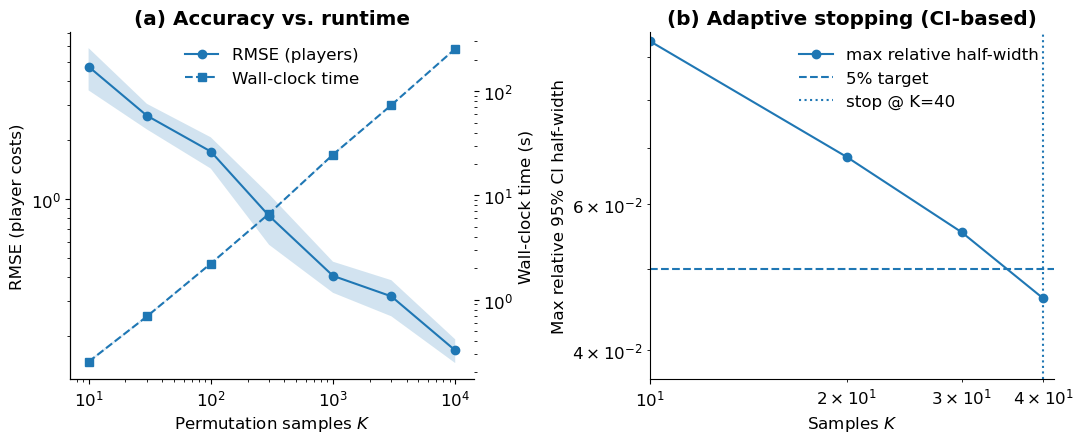

In [18]:

# 用法：
fig, axes = plot_sv_benchmark_panels(df_benchmark_results, stopping_results)
